# NIRSpec Merged Table

Demo of full merged table of NIRSpec spectra reduced with [msaexp](http://github.com/gbrammer/msaexp).  The merged columns are taken from the database tables

- `nirspec_extractions` - Basic spectrum parameters (grating, mask, exposure time, etc.)
- `nirspec_redshifts` - Redshift fit results, emission line fluxes
- `nirspec_redshifts_manual` - Grades and comments from visual inspection
- `nirspec_integrated` - Observed- and rest-frame filters integrated through the spectra at the derived redshift
- `grizli_photometry` - Photometry and some eazy outputs of the nearest counterpart in the DJA/grizli photometric catalogs

The public spectra are shown in a large overview table at [public_prelim_v4.2.html](https://s3.amazonaws.com/msaexp-nirspec/extractions/public_prelim_v4.2.html).

<a href="https://colab.research.google.com/github/gbrammer/voss-2025-jwst-data/blob/master/Notebooks/voss2025_jwst_spectroscopy.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg"> </a>


In [1]:
# Install dependencies, e.g., on Google Colab
try:
    import msaexp

except ImportError:

    ! pip install msaexp "grizli[jwst, aws]"
    ! pip install git+https://github.com/karllark/dust_attenuation.git

    import eazy
    eazy.fetch_eazy_photoz()

In [2]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import cKDTree

import astropy.io.fits as pyfits
from astropy.utils.data import download_file
from astropy.cosmology import WMAP9
import astropy.units as u

import grizli
import grizli.catalog
from grizli import utils

import eazy
import msaexp

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')
print(f'msaexp version: {msaexp.__version__}')

grizli version: 1.12.14
eazy-py version: 0.8.5
msaexp version: 0.9.8


## Read the table

In [3]:
# Full table
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')

In [4]:
# Column descriptions
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']

tab.info()

<GTable length=52181>
        name         dtype   unit  format                                       description                                           class     n_bad
------------------- ------- ------ ------ ---------------------------------------------------------------------------------------- ------------ -----
               file   str57                                                                                           DJA filename       Column     0
              srcid   int64                                                                                Source ID from APT plan       Column     0
                 ra float64    deg    .8f                                                                         RA from APT plan       Column     0
                dec float64    deg    .8f                                                                        Dec from APT plan       Column     0
            grating    str5                                                   

## Add some preview columns to the table

In [5]:
RGB_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}"
tab['metafile'] = [m.split('_')[0] for m in tab['msamet']]
SLIT_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile={metafile}"
FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"

tab['Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        RGB_URL.format(**row['ra','dec'])
    )
    for row in tab
]

tab['Slit_Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        SLIT_URL.format(**row['ra','dec','metafile'])
    )
    for row in tab
]

tab['Spectrum_fnu'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.fnu.png')
    )
    for row in tab
]

tab['Spectrum_flam'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.flam.png')
    )
    for row in tab
]


# zphot - zspec

11200


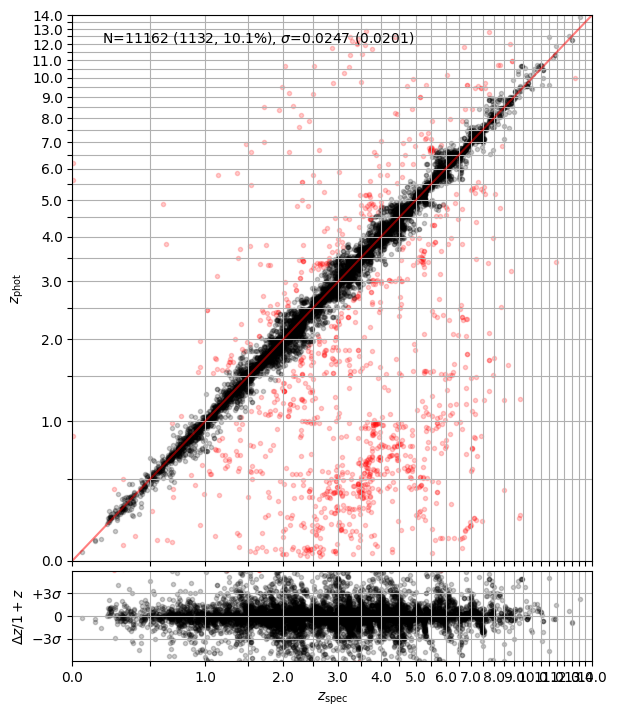

In [6]:
import eazy.utils
test = (tab['grade'] == 3) & (tab['z_phot'].filled(-1.) > 0)
test &= (tab['grating'] == 'PRISM')
print(test.sum())
_ = eazy.utils.zphot_zspec(tab['z_phot'][test], tab['z_best'][test], zmax=14)


In [7]:
# Counts by mask / program
utils.Unique(tab['root'])

   N  value     
====  ==========
 309  abell2744-castellano1-v4
 111  abell2744-ddt-v4
 230  abell2744-glass-v4
 137  aurora-gdn01-v4
 147  aurora-gdn02-v4
   9  bd-ic348-gto-v4
  25  bd-orion-gto-v4
 219  bluejay-north-v4
 223  bluejay-south-v4
  50  borg-0037m3337-v4
  38  borg-0314m6712-v4
  37  borg-0409m5317-v4
  36  borg-0440m5244-v4
  37  borg-0859p4114-v4
  45  borg-0955p4528-v4
  38  borg-1033p5051-v4
  43  borg-1437p5044-v4
  30  borg-2203p1851-v4
   5  cantalupo-filament-02-v4
 333  capers-cos01-v4
 416  capers-cos10-v4
 290  capers-cos13-v4
 372  capers-egs44-v4
 395  capers-egs47-v4
 404  capers-egs49-v4
 413  capers-egs53-v4
 324  capers-egs55-v4
 381  capers-egs61-v4
 343  capers-udsp1-v4
 299  capers-udsp2-v4
 278  capers-udsp3-v4
 168  capers-udsp5-v4
 102  cecilia-v4
 151  ceers-ddt-v4
1720  ceers-v4  
 340  cosmos-curti-v4
   1  cosmos-lae-martin-v4
 301  cosmos-transients-v4
 230  egs-mason-v4
 237  egs-nelsonx-v4
 125  excels-uds01-v4
 125  excels-uds02-v4
 135  e

## Source counts

Show magnitude, color, redshift distribution as a function of "grade":

- **Grade 3**: Robust redshift from one or more emission absorption features
- **2** Ambiguous continuum features, perhaps only one line or low confidence lines
- **1** No clear features in the spetrum to constrain the redshift
- **0** Spectrum suffers some data quality issue and should

   N  value     
====  ==========
3713          -1
  93           0
1283           1
 586           2
11200           3


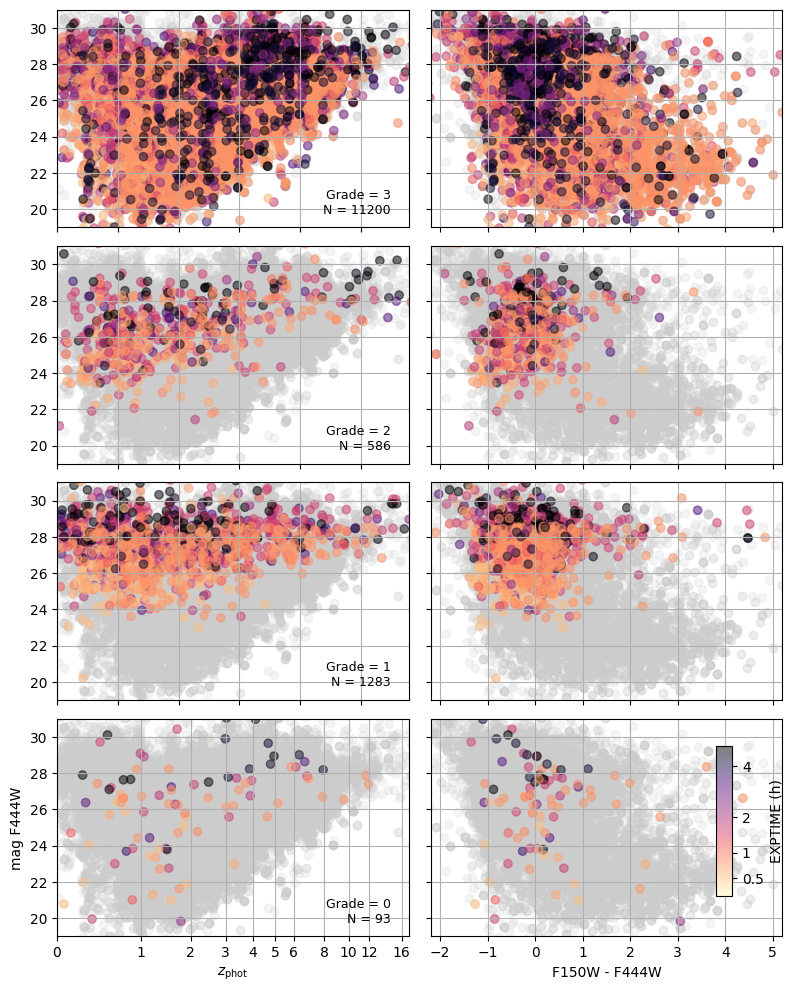

In [8]:
fig, axes = plt.subplots(4,2,figsize=(8,10), sharex=False, sharey=True)

colors = {0: 'magenta', 1: '0.5', 2: 'coral', 3: 'olive'}

# sub = is_rubies
sub = tab['ra'] > 0

sub = sub & True

sub &= tab['z_phot'].filled(-1) > 0
sub &= tab['grating'] == 'PRISM'

un = utils.Unique(tab[sub]['grade'].filled(-1))

blue = -2.5*np.log10(tab['phot_f150w_tot_1'] / tab['phot_f444w_tot_1'])

for i, c in enumerate([3,2,1,0]):

    kws = dict(
        c = np.sqrt(tab[sub][un[c]]['exptime']), vmin=900**0.5, vmax=(5*3600)**0.5, cmap='magma_r',
        # c = 'magenta',
        alpha=0.5,
        label=f'Grade = {c}',
    )

    ax = axes[i][1]
    ax.scatter(blue,
               23.9 - 2.5*np.log10(tab['phot_f444w_tot_1']),
               c='0.8',
               alpha=0.2,
               label=f'Grade = {c}',
    )

    sc = ax.scatter(blue[sub][un[c]],
               23.9 - 2.5*np.log10(tab[sub]['phot_f444w_tot_1'])[un[c]],
               **kws,
    )
    ax.grid()

    if i < 3:
        ax.set_xticklabels([])

    ax.set_xlim(-2.2, 5.2)

    ax = axes[i][0]

    ax.scatter(np.log(1+tab['z_phot']),
               23.9 - 2.5*np.log10(tab['phot_f444w_tot_1']),
               c='0.8',
               alpha=0.2,
               label=f'Grade = {c}' + '\n' + f'N = {un[c].sum()}',
    )

    ax.scatter(np.log(1+tab[sub]['z_phot'][un[c]]),
               23.9 - 2.5*np.log10(tab[sub]['phot_f444w_tot_1'])[un[c]],
               **kws,
    )

    ax.grid()
    ax.text(
        0.95, 0.05,
        # f'Grade = {c}',
        f'Grade = {c}' + '\n' + f'N = {un[c].sum()}',
        ha='right', va='bottom', fontsize=9, transform=ax.transAxes)

    if i < 3:
        ax.set_xticklabels([])

    xt = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16]
    ax.set_xlim(0, np.log(1+17))

ax.set_ylabel('mag F444W')

cax = fig.add_axes

cax = fig.add_axes((0.9, 0.1, 0.02, 0.15))
cb = plt.colorbar(sc, cax=cax, orientation='vertical')
ct = [0.5, 1, 2, 4]
cb.set_ticks(np.sqrt(np.array(ct)*3600))
cb.set_ticklabels(ct)
cb.set_label('EXPTIME (h)')

ax.set_ylim(19, 31)

ax.set_xticks(np.log(1+np.array(xt)))
ax.set_xticklabels(xt)
ax.set_xlabel(r'$z_\mathrm{phot}$')

ax = axes[3][1]

ax.set_xlabel('F150W - F444W')

# ax.legend()

fig.tight_layout(pad=1)


## PRISM sample for comparision

In [9]:
sample = (tab['grade'] == 3) & (tab['grating'] == 'PRISM')
sample &= tab['z_best'] < 7
sample &= tab['rest_153_frac'] > 0.8
sample &= tab['rest_154_frac'] > 0.8
sample &= tab['rest_155_frac'] > 0.8
sample.sum()

12708

## Interpolate Halpha EQW from nearby filters

Use interpolated EQW


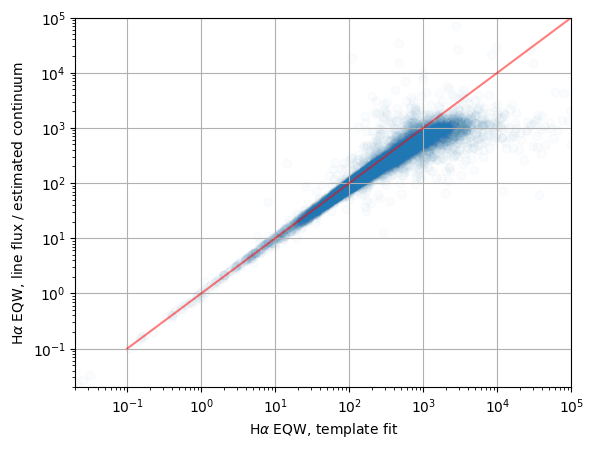

In [10]:
import eazy.filters
RES = eazy.filters.FilterFile()

fb, fr = 415, 416
#fb, fr = 155, 416
wb = RES[fb].pivot
wr = RES[fr].pivot

flamb = (1*u.microJansky).to(u.erg/u.second/u.cm**2/u.Angstrom, equivalencies=u.spectral_density(wb*u.Angstrom))
flamr = (1*u.microJansky).to(u.erg/u.second/u.cm**2/u.Angstrom, equivalencies=u.spectral_density(wr*u.Angstrom))

whtb = (1 - np.abs(wb - 6564.)/(wr-wb))# *flamb
whtr = (1 - np.abs(wr - 6564.)/(wr-wb))# *flamr

interp_flux = tab[f'rest_{fb}_flux']*whtb*flamb + tab[f'rest_{fr}_flux']*whtr*flamr

eqw = ((tab['line_ha_nii']*1.e-20*u.erg/u.second/u.cm**2 / (interp_flux / (1+tab['zline'])**1))).value

plt.scatter(
    (np.maximum(tab['eqw_ha_nii'], -100) / (1+tab['zline'])**1)[sample],
    eqw[sample], alpha=0.02
)
plt.plot([0.1, 1e7], [0.1, 1e7], color='r', alpha=0.5)
plt.loglog()
plt.grid()
plt.xlim(0.02, 1.e5); plt.ylim(0.02, 1.e5)
plt.xlabel(r'H$\alpha$ EQW, template fit')
plt.ylabel(r'H$\alpha$ EQW, line flux / estimated continuum')

if 1:
    print('Use interpolated EQW')
    eqw_lim = np.maximum(tab['line_ha_nii'], tab['line_ha_nii_err']*2) * 1.e-20*u.erg/u.second/u.cm**2 / (interp_flux / (1+tab['zline']))
    is_eqw_lim = tab['line_ha_nii_err']*2 > tab['line_ha_nii']
    eqw[is_eqw_lim] = eqw_lim.value[is_eqw_lim]
    tab['ha_eqw_with_limits'] = eqw
    tab['ha_eqw_is_limit'] = is_eqw_lim


# Stellar population properties

- Rest-frame colors
- Stellar masses
- ...

In [11]:
UV = -2.5*np.log10(tab['phot_restU'] / tab['phot_restV'])
VJ = -2.5*np.log10(tab['phot_restV'] / tab['phot_restJ'])

UVs = -2.5*np.log10(tab['rest_153_flux'] / tab['rest_155_flux'])
BVs = -2.5*np.log10(tab['rest_154_flux'] / tab['rest_155_flux'])
VJs = -2.5*np.log10(tab['rest_155_flux'] / tab['rest_161_flux'])

eBVs = 2.5/np.log(10) * np.sqrt(
    (tab['rest_154_full_err'] / tab['rest_154_flux'])**2
    + (tab['rest_155_full_err'] / tab['rest_155_flux'])**2
)

ugs = -2.5*np.log10(tab['rest_414_flux'] / tab['rest_415_flux'])
gis = -2.5*np.log10(tab['rest_415_flux'] / tab['rest_416_flux'])

ok_BVs = (tab['rest_154_frac'] > 0.8) & (tab['rest_155_frac'] > 0.8)
ok_gis = (tab['rest_415_frac'] > 0.8) & (tab['rest_416_frac'] > 0.8)

ok_BVs &= eBVs < 0.1

dL = WMAP9.luminosity_distance(tab['zrf']).to('cm')

rest_fV = (tab['rest_155_flux']*u.microJansky).to(
    u.erg/u.second/u.cm**2/u.Angstrom,
    equivalencies=u.spectral_density(5500.*(1+tab['zrf'])*u.Angstrom)
)

rest_fi = (tab['rest_416_flux']*u.microJansky).to(
    u.erg/u.second/u.cm**2/u.Angstrom,
    equivalencies=u.spectral_density(RES[416].pivot * (1+tab['zrf'])*u.Angstrom)
)

LV = (rest_fV * 5500. * u.Angstrom * (1 + tab['zrf']) * 4 * np.pi * dL**2).to(u.Lsun)
Li = (rest_fi * RES[416].pivot * u.Angstrom * (1 + tab['zrf']) * 4 * np.pi * dL**2).to(u.Lsun)


Text(0, 0.5, '$\\log M = \\log L_V + \\log M/L_V$\n$\\log M/L_V \\propto (B-V)$')

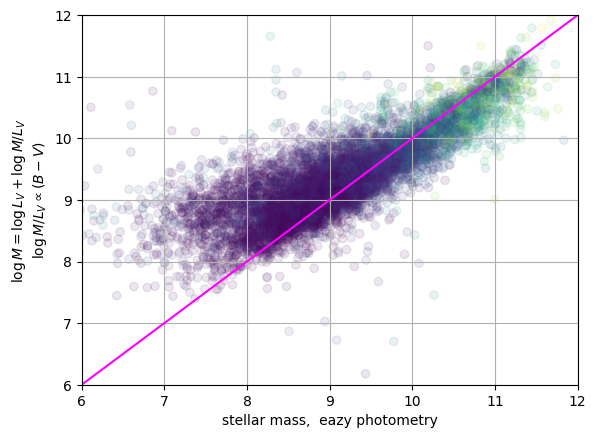

In [12]:
# Crude M/Lv ~ B-V from Taylor et al. 2009 for getting a quick stellar mass from the spectrum

log_MLv = -0.734 + 1.404 * (BVs + 0.084)
MassV = log_MLv + np.log10(LV.value)

tab['Mass'] = MassV
tab['Mass'].format = '.2f'
tab['ok_Mass'] = ok_BVs

plt.scatter(
    np.log10(tab['phot_mass'][sample & ok_BVs]),
    MassV[sample & ok_BVs],
    alpha=0.1,
    c=tab['phot_Av'][sample & ok_BVs]
)

plt.plot([5, 12], [5, 12], color='magenta')
plt.grid()
plt.xlim(6, 12)
plt.ylim(6, 12)
plt.xlabel('stellar mass,  eazy photometry')
plt.ylabel(r'$\log M = \log L_V + \log M/L_V$' + '\n' + r'$\log M/L_V \propto (B-V)$')

## Compare rest-frame colors

The table includes rest-frame bandpass flux densities 1) estimated from the broad-band photometry (at the photo-z) and 2) integrated directly through the spectra at the measured redshift.  

The colors derived from the  grizli/DJA *photometry* are those of the best-fit photo-z template combination, not a noisy interpolation, so they can show banding effects resulting from the discrete combination of templates.

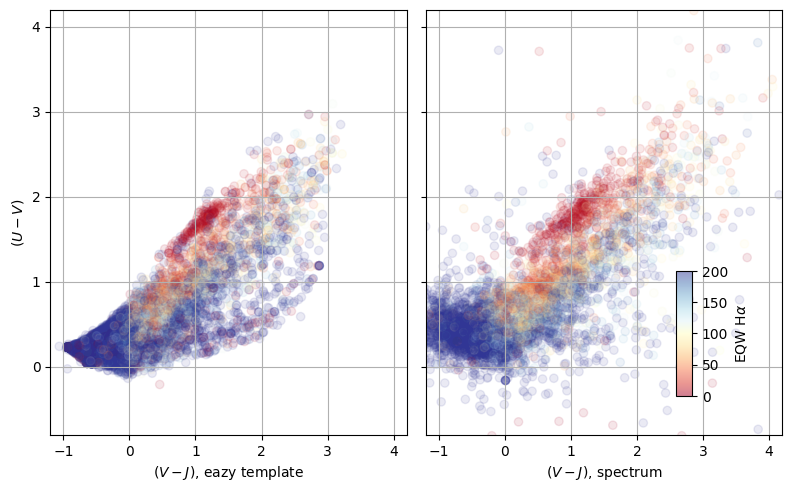

In [13]:
fig, axes = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)

axes[0].scatter(
    VJ[sample], UV[sample], alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)
axes[0].set_xlabel(r'$(V-J)$' + ', eazy template')
axes[0].set_ylabel(r'$(U-V)$')

axes[1].scatter(
    VJs[sample], UVs[sample], alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)

sc = axes[1].scatter(
    VJs[sample][:1], UVs[sample][:1], alpha=0.5,
    c=tab['ha_eqw_with_limits'][sample][:1], vmin=0, vmax=200, cmap='RdYlBu'
)

axes[1].set_xlabel(r'$(V-J)$' + ', spectrum')

for ax in axes:
    ax.set_xlim(-1.2, 4.2)
    ax.set_ylim(-0.8, 4.2)
    ax.grid()

cax = fig.add_axes((0.85, 0.2, 0.02, 0.25))
cb = plt.colorbar(sc, cax=cax, orientation='vertical')
cb.set_label(r'EQW H$\alpha$')

fig.tight_layout(pad=1)

Text(0, 0.5, 'rough stellar mass')

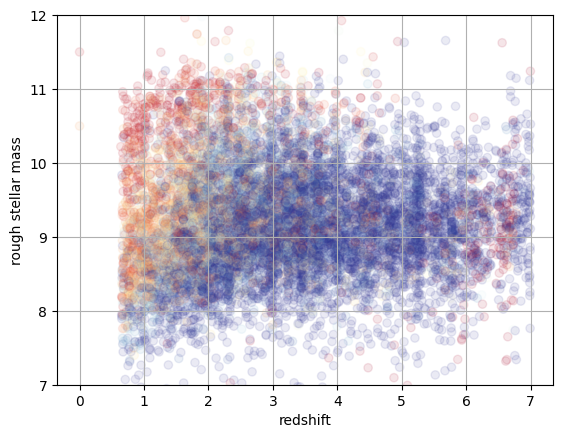

In [14]:
plt.scatter(
    tab['z_best'][sample],
    # np.log10(tab['phot_mass'])[sample],
    tab['Mass'][sample],
    alpha=0.1,
    c=tab['ha_eqw_with_limits'][sample], vmin=0, vmax=200, cmap='RdYlBu'
)
plt.ylim(7, 12)
plt.grid()
plt.xlabel('redshift')
plt.ylabel('rough stellar mass')

In [15]:
# Make a preview table
massive = sample & (tab['z_best'] > 4.) & (MassV > 10.5) & (tab['grating'] == 'PRISM') & ok_BVs

if 0:
    tab['root','file','z_best','Mass','ha_eqw_with_limits','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'][massive].write_sortable_html(
        '/tmp/massive.html',
        max_lines=1000,
        localhost=False,
    )

print(f"massive test sample: {massive.sum()}")

massive test sample: 69


In [16]:
from IPython.display import display, Markdown, Latex

so = np.argsort(tab['Mass'][massive])[::-1]
so = so[:32]

df = tab['root','file','z_best','Mass','ha_eqw_with_limits','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'][massive][so].to_pandas()

display(Markdown(df.to_markdown()))

|    | root                | file                                                |   z_best |    Mass |   ha_eqw_with_limits | Thumb                                                                                                                                                                                                         | Slit_Thumb                                                                                                                                                                                                                                                  | Spectrum_fnu                                                                                                                                       | Spectrum_flam                                                                                                                                       |
|---:|:--------------------|:----------------------------------------------------|---------:|--------:|---------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | j0910-wang-v4       | j0910-wang-v4_prism-clear_2028_12910.spec.fits      |  6.62142 | 12.0515 |             54.4902  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=137.72721162%2C-4.23520691" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=137.72721162%2C-4.23520691&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02028001001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/j0910-wang-v4/j0910-wang-v4_prism-clear_2028_12910.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/j0910-wang-v4/j0910-wang-v4_prism-clear_2028_12910.flam.png" height=200px>            |
|  1 | rubies-uds23-v4     | rubies-uds23-v4_prism-clear_4233_166691.spec.fits   |  4.06673 | 11.9254 |             11.4969  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36378034%2C-5.11191402" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36378034%2C-5.11191402&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_166691.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_166691.flam.png" height=200px>       |
|  2 | uncover-61-v4       | uncover-61-v4_prism-clear_2561_13416.spec.fits      |  4.02262 | 11.7896 |            114.235   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.57556471%2C-30.42438021" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.57556471%2C-30.42438021&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561006001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v4/uncover-61-v4_prism-clear_2561_13416.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v4/uncover-61-v4_prism-clear_2561_13416.flam.png" height=200px>            |
|  3 | rubies-egs52-v4     | rubies-egs52-v4_prism-clear_4233_9809.spec.fits     |  5.68123 | 11.6563 |            197.61    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=215.01729764%2C52.88015836" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=215.01729764%2C52.88015836&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233005002" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs52-v4/rubies-egs52-v4_prism-clear_4233_9809.fnu.png" height=200px>         | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs52-v4/rubies-egs52-v4_prism-clear_4233_9809.flam.png" height=200px>         |
|  4 | jades-gdn-v4        | jades-gdn-v4_prism-clear_1181_68797.spec.fits       |  5.03971 | 11.6303 |           1054.65    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2291371%2C62.1461898" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2291371%2C62.1461898&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181098001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn-v4/jades-gdn-v4_prism-clear_1181_68797.fnu.png" height=200px>              | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn-v4/jades-gdn-v4_prism-clear_1181_68797.flam.png" height=200px>              |
|  5 | rubies-uds22-v4     | rubies-uds22-v4_prism-clear_4233_114988.spec.fits   |  4.36474 | 11.5051 |             94.5801  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.29794136%2C-5.18436854" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.29794136%2C-5.18436854&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002002" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds22-v4/rubies-uds22-v4_prism-clear_4233_114988.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds22-v4/rubies-uds22-v4_prism-clear_4233_114988.flam.png" height=200px>       |
|  6 | gto-wide-uds13-v4   | gto-wide-uds13-v4_prism-clear_1215_1472.spec.fits   |  4.55596 | 11.4348 |             14.736   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33731548%2C-5.1436736" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33731548%2C-5.1436736&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_1472.fnu.png" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_1472.flam.png" height=200px>     |
|  7 | uncover-v4          | uncover-v4_prism-clear_2561_45924.spec.fits         |  4.4673  | 11.3522 |            104.309   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.58476007%2C-30.34362753" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.58476007%2C-30.34362753&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561002004" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v4/uncover-v4_prism-clear_2561_45924.fnu.png" height=200px>                  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v4/uncover-v4_prism-clear_2561_45924.flam.png" height=200px>                  |
|  8 | uncover-62-v4       | uncover-62-v4_prism-clear_2561_58453.spec.fits      |  4.4673  | 11.2252 |            969.994   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.58475839%2C-30.34362894" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.58475839%2C-30.34362894&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561006002" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-62-v4/uncover-62-v4_prism-clear_2561_58453.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-62-v4/uncover-62-v4_prism-clear_2561_58453.flam.png" height=200px>            |
|  9 | gds-barrufet-s67-v4 | gds-barrufet-s67-v4_prism-clear_2198_1260.spec.fits |  4.4319  | 11.2251 |             72.7017  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.07485578%2C-27.87589702" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.07485578%2C-27.87589702&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02198003001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_1260.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_1260.flam.png" height=200px> |
| 10 | rubies-egs63-v4     | rubies-egs63-v4_prism-clear_4233_49140.spec.fits    |  6.68959 | 11.1816 |            657.49    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.89224786%2C52.87740968" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.89224786%2C52.87740968&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006003" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs63-v4/rubies-egs63-v4_prism-clear_4233_49140.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs63-v4/rubies-egs63-v4_prism-clear_4233_49140.flam.png" height=200px>        |
| 11 | rubies-uds42-v4     | rubies-uds42-v4_prism-clear_4233_807469.spec.fits   |  6.77538 | 11.1462 |           4951.05    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3761391%2C-5.3103658" height=200px>    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3761391%2C-5.3103658&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233004002" height=200px>    | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v4/rubies-uds42-v4_prism-clear_4233_807469.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds42-v4/rubies-uds42-v4_prism-clear_4233_807469.flam.png" height=200px>       |
| 12 | rubies-egs61-v4     | rubies-egs61-v4_prism-clear_4233_55604.spec.fits    |  6.98435 | 11.1174 |           2762.98    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.98302557%2C52.9560013" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.98302557%2C52.9560013&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_55604.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_55604.flam.png" height=200px>        |
| 13 | uncover-62-v4       | uncover-62-v4_prism-clear_2561_59554.spec.fits      |  4.47252 | 11.0693 |            155.997   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.57201994%2C-30.34249594" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.57201994%2C-30.34249594&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561006002" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-62-v4/uncover-62-v4_prism-clear_2561_59554.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-62-v4/uncover-62-v4_prism-clear_2561_59554.flam.png" height=200px>            |
| 14 | rubies-uds31-v4     | rubies-uds31-v4_prism-clear_4233_149494.spec.fits   |  4.62235 | 11.0691 |              5.34271 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.39967589%2C-5.13634805" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.39967589%2C-5.13634805&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233003001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-v4/rubies-uds31-v4_prism-clear_4233_149494.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds31-v4/rubies-uds31-v4_prism-clear_4233_149494.flam.png" height=200px>       |
| 15 | capers-egs49-v4     | capers-egs49-v4_prism-clear_6368_11585.spec.fits    |  6.68959 | 10.9733 |            480.117   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.8922488%2C52.8774032" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.8922488%2C52.8774032&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368049001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-egs49-v4/capers-egs49-v4_prism-clear_6368_11585.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-egs49-v4/capers-egs49-v4_prism-clear_6368_11585.flam.png" height=200px>        |
| 16 | rubies-uds23-v4     | rubies-uds23-v4_prism-clear_4233_140707.spec.fits   |  4.62    | 10.908  |             10.0372  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36508449%2C-5.14884841" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36508449%2C-5.14884841&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_140707.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_140707.flam.png" height=200px>       |
| 17 | rubies-uds23-v4     | rubies-uds23-v4_prism-clear_4233_148866.spec.fits   |  5.22256 | 10.9076 |            262.927   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.32643349%2C-5.13738186" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.32643349%2C-5.13738186&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_148866.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_148866.flam.png" height=200px>       |
| 18 | egs-nelsonx-v4      | egs-nelsonx-v4_prism-clear_4106_57146.spec.fits     |  6.68959 | 10.8953 |            471.6     | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.89224643%2C52.87740951" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.89224643%2C52.87740951&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04106006001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/egs-nelsonx-v4/egs-nelsonx-v4_prism-clear_4106_57146.fnu.png" height=200px>          | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/egs-nelsonx-v4/egs-nelsonx-v4_prism-clear_4106_57146.flam.png" height=200px>          |
| 19 | gto-wide-uds13-v4   | gto-wide-uds13-v4_prism-clear_1215_6001.spec.fits   |  4.58301 | 10.8825 |            716.686   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36424834%2C-5.1977302" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.36424834%2C-5.1977302&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_6001.fnu.png" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_prism-clear_1215_6001.flam.png" height=200px>     |
| 20 | rubies-uds2-v4      | rubies-uds2-v4_prism-clear_b28.spec.fits            |  4.36275 | 10.8802 |              5.61715 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001002" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_b28.fnu.png" height=200px>                 | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_b28.flam.png" height=200px>                 |
| 21 | rubies-uds2-v4      | rubies-uds2-v4_prism-clear_4233_b28.spec.fits       |  4.36275 | 10.8801 |              5.59212 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001002" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_4233_b28.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_4233_b28.flam.png" height=200px>            |
| 22 | rubies-egs61-v4     | rubies-egs61-v4_prism-clear_4233_75646.spec.fits    |  4.90002 | 10.874  |             24.3336  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.flam.png" height=200px>        |
| 23 | goodsn-wide2-v4     | goodsn-wide2-v4_prism-clear_1211_10.spec.fits       |  4.14019 | 10.8389 |            236.904   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.14356704%2C62.16166621" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.14356704%2C62.16166621&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01211014001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide2-v4/goodsn-wide2-v4_prism-clear_1211_10.fnu.png" height=200px>           | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide2-v4/goodsn-wide2-v4_prism-clear_1211_10.flam.png" height=200px>           |
| 24 | uncover-61-v4       | uncover-61-v4_prism-clear_2561_21547.spec.fits      |  5.05789 | 10.8387 |            553.345   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.55083778%2C-30.40659783" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.55083778%2C-30.40659783&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561006001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v4/uncover-61-v4_prism-clear_2561_21547.fnu.png" height=200px>            | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-61-v4/uncover-61-v4_prism-clear_2561_21547.flam.png" height=200px>            |
| 25 | jades-gdn2-v4       | jades-gdn2-v4_prism-clear_1181_954.spec.fits        |  6.76117 | 10.8335 |           1997.48    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1519657%2C62.2596352" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1519657%2C62.2596352&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181007001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_prism-clear_1181_954.fnu.png" height=200px>              | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_prism-clear_1181_954.flam.png" height=200px>              |
| 26 | rubies-egs53-v4     | rubies-egs53-v4_prism-clear_4233_42046.spec.fits    |  5.27719 | 10.8159 |           1213.54    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.79536781%2C52.78884663" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.79536781%2C52.78884663&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233005003" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v4/rubies-egs53-v4_prism-clear_4233_42046.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v4/rubies-egs53-v4_prism-clear_4233_42046.flam.png" height=200px>        |
| 27 | snh0pe-v4           | snh0pe-v4_prism-clear_4446_274.spec.fits            |  4.10583 | 10.8132 |              4.80224 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=171.82361288%2C42.46963868" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=171.82361288%2C42.46963868&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04446001001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/snh0pe-v4/snh0pe-v4_prism-clear_4446_274.fnu.png" height=200px>                      | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/snh0pe-v4/snh0pe-v4_prism-clear_4446_274.flam.png" height=200px>                      |
| 28 | rubies-uds23-v4     | rubies-uds23-v4_prism-clear_4233_155916.spec.fits   |  4.09409 | 10.7958 |             47.1011  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3170308%2C-5.12761145" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3170308%2C-5.12761145&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_155916.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_prism-clear_4233_155916.flam.png" height=200px>       |
| 29 | uncover-v4          | uncover-v4_prism-clear_2561_4286.spec.fits          |  5.83522 | 10.7673 |            730.932   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.61920101%2C-30.42327034" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=3.61920101%2C-30.42327034&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02561002002" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v4/uncover-v4_prism-clear_2561_4286.fnu.png" height=200px>                   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/uncover-v4/uncover-v4_prism-clear_2561_4286.flam.png" height=200px>                   |
| 30 | jades-gds-w07-v4    | jades-gds-w07-v4_prism-clear_1212_6071.spec.fits    |  5.55195 | 10.7579 |           1022.83    | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.16270355%2C-27.8731285" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.16270355%2C-27.8731285&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01212007001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-w07-v4/jades-gds-w07-v4_prism-clear_1212_6071.fnu.png" height=200px>       | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-w07-v4/jades-gds-w07-v4_prism-clear_1212_6071.flam.png" height=200px>       |
| 31 | rubies-uds43-v4     | rubies-uds43-v4_prism-clear_4233_19735.spec.fits    |  4.8047  | 10.7567 |            241.777   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.30109423%2C-5.28798532" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.30109423%2C-5.28798532&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233004003" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds43-v4/rubies-uds43-v4_prism-clear_4233_19735.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds43-v4/rubies-uds43-v4_prism-clear_4233_19735.flam.png" height=200px>        |

## Read a spectrum

![ruby](https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.fnu.png)

In [17]:
import msaexp.spectrum
spec_file = 'rubies-egs61-v4_prism-clear_4233_75646.spec.fits'
row = tab[tab['file'] == spec_file][0]
spec = msaexp.spectrum.SpectrumSampler(FITS_URL.format(**row))

In [18]:
row['Mass']

10.873998434439217

In [19]:
spec.spec.info

<GTable length=473>
    name     dtype  unit                description                   class     n_bad
----------- ------- ---- ----------------------------------------- ------------ -----
       wave float64                                                      Column     0
       flux float64                                                      Column     0
        err float64                                                      Column     0
        sky float64  uJy                                           MaskedColumn     5
  path_corr float64                                                MaskedColumn     5
       npix float64                                                      Column     0
   flux_sum float64                                                      Column     0
profile_sum float64                                                      Column     0
    var_sum float64                                                      Column     0
       corr float64               

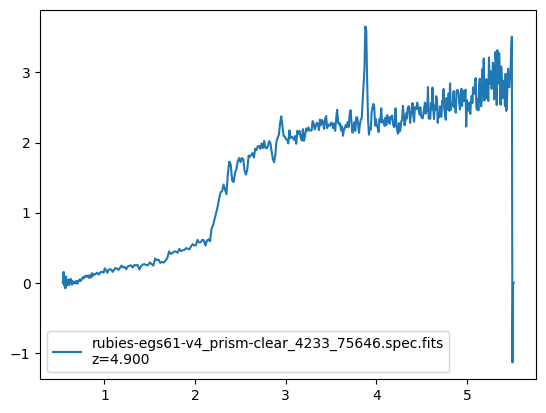

In [20]:
plt.plot(spec['wave'], spec['flux'],
         label="{file}\nz={z_best:.3f}".format(**row))
plt.legend()

# All `msaexp` PRISM spectra in a single table

In [21]:
combined_spectra_file = "dja_msaexp_emission_lines_v4.0.prism_spectra.fits"

if os.path.exists(combined_spectra_file):
    prism_spectra = utils.read_catalog(combined_spectra_file)
else:
    # Combined prism spectra in a single big table (595 Mb)
    prism_spectra = utils.read_catalog(
        download_file(
            f"https://s3.amazonaws.com/msaexp-nirspec/extractions/{combined_spectra_file}",
            cache=True
        ),
        format='fits',
    )

In [22]:
is_prism = tab['grating'] == 'PRISM'
tab['prism_idx'] = 0
tab['prism_idx'][is_prism] = np.arange(is_prism.sum())

print(f"""
PRISM spectra in the merged catalog: {is_prism.sum()}
PRISM spectra in the combined table: {prism_spectra['flux'].shape[1]}
""")


PRISM spectra in the merged catalog: 26913
PRISM spectra in the combined table: 26913



In [23]:
valid_count = prism_spectra['valid'].sum(axis=0)
valid_spec = valid_count > (valid_count.max() - 8)

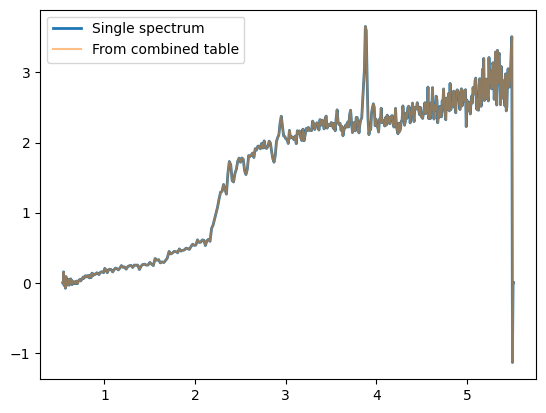

In [24]:
row = tab[tab['file'] == spec_file][0]

plt.plot(
    spec['wave'], spec['flux'],
    lw=2, label='Single spectrum'
)

plt.plot(
    prism_spectra['wave'], prism_spectra['flux'][:, row['prism_idx']],
    alpha=0.5, label='From combined table'
)

plt.legend()

## "Stacked" spectrum

Stacking prism spectra isn't trivial due to the variable dispersion and wavelength sampling.  Here just plot a subset on top of eachother.

Normalization column: 'rest_416_flux' = Spectrum flux in synthetic_i


(-1.0, 10.0)

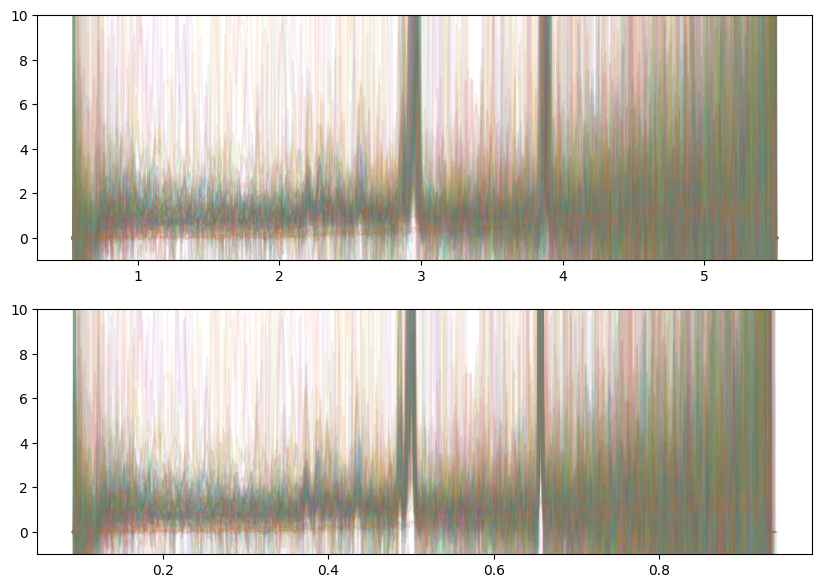

In [25]:
norm_column = 'rest_416_flux'
print(f"Normalization column: '{norm_column}' = {tab[norm_column].description}")

flux_norm = prism_spectra['flux'] / tab[norm_column][is_prism]

# Subset
zi = row['z_best']
dz = 0.05

sample = (tab['z_best'] > zi - dz) & (tab['z_best'] < zi + dz)

sub_sample = sample[is_prism] & valid_spec
sub_idx = np.where(sub_sample)[0]

z_sample = tab['z_best'][is_prism][sample[is_prism] & valid_spec]

fig, axes = plt.subplots(2,1,figsize=(10,7), sharex=False, sharey=True)

for j, z in enumerate(z_sample):
    axes[0].plot(
        prism_spectra['wave'],
        flux_norm[:, sub_idx[j]],
        alpha=0.1
    )

    axes[1].plot(
        prism_spectra['wave'] / (1 + z),
        flux_norm[:, sub_idx[j]],
        alpha=0.1
    )


axes[0].set_ylim(-1, 10)

# "Nearest neighbor" spectra

Simple "nearest neighbors" of the normalized spectra.

In [26]:
fix_flux_norm = flux_norm*1.
fix_flux_norm[~np.isfinite(flux_norm)] = 0

tr = cKDTree(fix_flux_norm[:, valid_spec].T)
tr_ds, tr_idx = tr.query(fix_flux_norm[:, row['prism_idx']], k=16)

df = tab['root','file','z_best','Mass','ha_eqw_with_limits','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'][is_prism][valid_spec][tr_idx].to_pandas()

display(Markdown(df.to_markdown()))


|    | root                   | file                                                    |   z_best |    Mass |   ha_eqw_with_limits | Thumb                                                                                                                                                                                                         | Slit_Thumb                                                                                                                                                                                                                                                  | Spectrum_fnu                                                                                                                                              | Spectrum_flam                                                                                                                                              |
|---:|:-----------------------|:--------------------------------------------------------|---------:|--------:|---------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | rubies-egs61-v4        | rubies-egs61-v4_prism-clear_4233_75646.spec.fits        |  4.90002 | 10.874  |             24.3336  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.fnu.png" height=200px>               | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_75646.flam.png" height=200px>               |
|  1 | gds-barrufet-s67-v4    | gds-barrufet-s67-v4_prism-clear_2198_8777.spec.fits     |  4.65301 | 10.6769 |              8.26113 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.10820397%2C-27.82518775" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.10820397%2C-27.82518775&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02198003001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_8777.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_8777.flam.png" height=200px>        |
|  2 | gds-barrufet-s67-v4    | gds-barrufet-s67-v4_prism-clear_2198_8290.spec.fits     |  4.34386 | 10.5556 |              4.0581  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.08187859%2C-27.82879899" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.08187859%2C-27.82879899&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02198003001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_8290.fnu.png" height=200px>        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-barrufet-s67-v4/gds-barrufet-s67-v4_prism-clear_2198_8290.flam.png" height=200px>        |
|  3 | jades-gdn09-v4         | jades-gdn09-v4_prism-clear_1181_72127.spec.fits         |  4.13368 | 10.5771 |             75.7974  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2657184%2C62.1683933" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2657184%2C62.1683933&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181009001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v4/jades-gdn09-v4_prism-clear_1181_72127.fnu.png" height=200px>                 | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v4/jades-gdn09-v4_prism-clear_1181_72127.flam.png" height=200px>                 |
|  4 | glazebrook-cos-obs1-v4 | glazebrook-cos-obs1-v4_prism-clear_2565_10559.spec.fits |  4.28971 | 10.5518 |              3.80496 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=150.07143593%2C2.29117893" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=150.07143593%2C2.29117893&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02565301001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-cos-obs1-v4/glazebrook-cos-obs1-v4_prism-clear_2565_10559.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-cos-obs1-v4/glazebrook-cos-obs1-v4_prism-clear_2565_10559.flam.png" height=200px> |
|  5 | jades-gds-wide-v4      | jades-gds-wide-v4_prism-clear_1180_12619.spec.fits      |  3.60805 | 10.6324 |             27.8163  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.1969096%2C-27.7605277" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.1969096%2C-27.7605277&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01180029001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-wide-v4/jades-gds-wide-v4_prism-clear_1180_12619.fnu.png" height=200px>           | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-wide-v4/jades-gds-wide-v4_prism-clear_1180_12619.flam.png" height=200px>           |
|  6 | rubies-uds2-v4         | rubies-uds2-v4_prism-clear_b28.spec.fits                |  4.36275 | 10.8802 |              5.61715 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001002" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_b28.fnu.png" height=200px>                        | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_b28.flam.png" height=200px>                        |
|  7 | rubies-uds2-v4         | rubies-uds2-v4_prism-clear_4233_b28.spec.fits           |  4.36275 | 10.8801 |              5.59212 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2805153%2C-5.21721404&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001002" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_4233_b28.fnu.png" height=200px>                   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds2-v4/rubies-uds2-v4_prism-clear_4233_b28.flam.png" height=200px>                   |
|  8 | glazebrook-cos-obs3-v4 | glazebrook-cos-obs3-v4_prism-clear_2565_20115.spec.fits |  3.71293 | 11.2231 |              2.61723 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=150.06146711%2C2.37868632" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=150.06146711%2C2.37868632&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02565007001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-cos-obs3-v4/glazebrook-cos-obs3-v4_prism-clear_2565_20115.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-cos-obs3-v4/glazebrook-cos-obs3-v4_prism-clear_2565_20115.flam.png" height=200px> |
|  9 | gto-wide-egs1-v4       | gto-wide-egs1-v4_prism-clear_1213_4358.spec.fits        |  4.28982 | 10.6918 |             21.9825  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=215.03907944%2C53.0027735" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=215.03907944%2C53.0027735&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01213002001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-egs1-v4/gto-wide-egs1-v4_prism-clear_1213_4358.fnu.png" height=200px>              | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-egs1-v4/gto-wide-egs1-v4_prism-clear_1213_4358.flam.png" height=200px>              |
| 10 | jades-gdn09-v4         | jades-gdn09-v4_prism-clear_1181_80660.spec.fits         |  4.39946 | 10.2177 |             25.751   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2754487%2C62.2141353" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2754487%2C62.2141353&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181009001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v4/jades-gdn09-v4_prism-clear_1181_80660.fnu.png" height=200px>                 | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v4/jades-gdn09-v4_prism-clear_1181_80660.flam.png" height=200px>                 |
| 11 | glazebrook-v4          | glazebrook-v4_prism-clear_2565_10459.spec.fits          |  3.98685 | 10.6829 |              4.65304 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.34034528%2C-5.24130895" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.34034528%2C-5.24130895&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02565100001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-v4/glazebrook-v4_prism-clear_2565_10459.fnu.png" height=200px>                   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-v4/glazebrook-v4_prism-clear_2565_10459.flam.png" height=200px>                   |
| 12 | jades-gdn-v4           | jades-gdn-v4_prism-clear_1181_76320.spec.fits           |  3.23859 | 10.3316 |              4.69578 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2214567%2C62.1924022" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.2214567%2C62.1924022&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181098001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn-v4/jades-gdn-v4_prism-clear_1181_76320.fnu.png" height=200px>                     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn-v4/jades-gdn-v4_prism-clear_1181_76320.flam.png" height=200px>                     |
| 13 | capers-egs49-v4        | capers-egs49-v4_prism-clear_6368_7806.spec.fits         |  3.44385 | 10.285  |             33.2528  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.8790898%2C52.8880604" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.8790898%2C52.8880604&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368049001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-egs49-v4/capers-egs49-v4_prism-clear_6368_7806.fnu.png" height=200px>                | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-egs49-v4/capers-egs49-v4_prism-clear_6368_7806.flam.png" height=200px>                |
| 14 | glazebrook-v4          | glazebrook-v4_prism-clear_2565_35168.spec.fits          |  3.71777 | 10.2866 |              7.84772 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.48515%2C-5.1578067" height=200px>      | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.48515%2C-5.1578067&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw02565300001" height=200px>      | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-v4/glazebrook-v4_prism-clear_2565_35168.fnu.png" height=200px>                   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/glazebrook-v4/glazebrook-v4_prism-clear_2565_35168.flam.png" height=200px>                   |
| 15 | jades-gds-w03-v4       | jades-gds-w03-v4_prism-clear_1212_1231.spec.fits        |  4.34386 | 10.4459 |              3.51736 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.08191171%2C-27.82880802" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=53.08191171%2C-27.82880802&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01212003001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-w03-v4/jades-gds-w03-v4_prism-clear_1212_1231.fnu.png" height=200px>              | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gds-w03-v4/jades-gds-w03-v4_prism-clear_1212_1231.flam.png" height=200px>              |

## Thumbnail API

The DJA thumbnail API can create thumbnail figures and FITS cutouts of a requested set of filters at a particular coordinate.M

In [27]:
from IPython.display import Image
print(RGB_URL.format(**row))
Image(url=RGB_URL.format(**row), height=300, width=300)


https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831


In [28]:
print(SLIT_URL.format(**row))
Image(url=SLIT_URL.format(**row), height=300, width=300)

https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=214.91554591%2C52.94901831&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233006001


# Full redrizzle cutout from exposures

In [29]:
from grizli import utils, grismconf
from grizli.aws import db

from grizli.aws import visit_processor, db
import os

env = {
    'CRDS_PATH': '/tmp/crds_cache',
    'CRDS_SERVER_URL': 'https://jwst-crds.stsci.edu'
}
for k in env:
    if os.getenv(k) is None:
        print(f'set {k} = {env[k]}')
        os.environ[k] = env[k]

CONF_DIR = os.path.join(utils.GRIZLI_PATH, "CONF")
if not os.path.exists(CONF_DIR):
    os.makedirs(CONF_DIR)

utils.fetch_config_files(get_sky=False, get_wfc3=False, get_jwst=True)
grismconf.download_jwst_crds_references()

Set ROOT_PATH=/content
set CRDS_PATH = /tmp/crds_cache
set CRDS_SERVER_URL = https://jwst-crds.stsci.edu
Config directory: /usr/local/lib/python3.11/dist-packages/grizli/data//CONF
File PSFSTD_WFC3IR_F105W.fits exists
File PSFSTD_WFC3IR_F125W.fits exists
File PSFSTD_WFC3IR_F140W.fits exists
File PSFSTD_WFC3IR_F160W.fits exists
File PSFSTD_WFC3IR_F110W.fits exists
File PSFSTD_WFC3IR_F127M.fits exists
Templates directory: /usr/local/lib/python3.11/dist-packages/grizli/data//templates
File stars_pickles.npy exists
File stars_bpgs.npy exists
ln -s stars_pickles.npy stars.npy
ENV CRDS_CONTEXT = jwst_1123.pmap
crds_reffiles: NIRCAM F277W GRISMR A (jwst_1123.pmap)
crds_reffiles: jwst_nircam_photom_0130.fits jwst_nircam_specwcs_0186.asdf
ENV CRDS_CONTEXT = jwst_1123.pmap
crds_reffiles: NIRCAM F277W GRISMR B (jwst_1123.pmap)
crds_reffiles: jwst_nircam_photom_0129.fits jwst_nircam_specwcs_0160.asdf
ENV CRDS_CONTEXT = jwst_1123.pmap
crds_reffiles: NIRCAM F277W GRISMC A (jwst_1123.pmap)
crds_reffi

In [30]:
def download_res_files(res):
    """
    Download a list of files in the query response
    """
    FILE_URL = "http://s3.amazonaws.com/grizli-v2/HST/Pipeline/{assoc}/Prep/{dataset}_rate.fits"
    for row in res:
        file_i = FILE_URL.format(**row)
        local_file = os.path.basename(file_i)
        if not os.path.exists(local_file):
            print(file_i)
            with pyfits.open(download_file(file_i, cache=True)) as im:
                im.writeto(local_file, overwrite=True)

        else:
            print(local_file)




In [31]:
# Query DJA exposures that cover a particular position
res = utils.read_catalog(SLIT_URL.format(**row).replace('/thumb','/exposures'), format='csv')

download_res_files(res)


jw01345002001_14201_00002_nrcblong_rate.fits
jw01345002001_14201_00001_nrcblong_rate.fits
jw01345002001_14201_00003_nrcblong_rate.fits


In [32]:
res.to_pandas()

,file,extension,dataset,assoc,parent,filter,pupil,mdrizsky,exptime,expstart,...,ra2,dec2,ra3,dec3,ra4,dec4,footprint,modtime,chipsky,eid
0,jw01345002001_14201_00002_nrcblong,rate,jw01345002001_14201_00002_nrcblong,j141940p5254_unknown-f444w_00066,indef-01345-002-131.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.263146,944.836,59752.120,...,214.92467,52.907207,214.96286,52.934143,214.91814,52.957867,"((214.879,52.9304),(214.925,52.9072),(214.963,...",60008.703,0.0,224234
1,jw01345002001_14201_00001_nrcblong,rate,jw01345002001_14201_00001_nrcblong,j141940p5254_unknown-f444w_00066,indef-01345-002-131.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.262577,944.836,59752.105,...,214.92560,52.907270,214.96379,52.934208,214.91905,52.957928,"((214.88,52.9305),(214.926,52.9073),(214.964,5...",60008.703,0.0,224226
2,jw01345002001_14201_00003_nrcblong,rate,jw01345002001_14201_00003_nrcblong,j141940p5254_unknown-f444w_00066,indef-01345-002-131.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.263544,944.836,59752.133,...,214.92375,52.907146,214.96194,52.934086,214.91720,52.957806,"((214.878,52.9304),(214.924,52.9071),(214.962,...",60008.703,0.0,224241


In [33]:
cutout = visit_processor.cutout_mosaic(
    rootname="cutout",
    ra=row['ra'], dec=row['dec'],
    filters=['F444W-CLEAR'],
    clean_flt=False,
    s3output=None,
    res=res,
    ir_scale=0.04,
    half_optical=False,
    size=1.5 * 2,
    kernel='square',
    pixfrac=0.5,
    make_exptime_map=False,
    skip_existing=False,
)

============ cutout-f444w-clear============

(   1/   3) Add exposure jw01345002001_14201_00001_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=150 plus=68
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 79277  ( 2e+00 %)
Found 0 saturated pixels in 0  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.373  0.371  scale = 0.995
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+NO_SAT_CHECK+NO_GAIN_VALUE+HOT+WARM+DEAD+RC+LOW_QE = 10973665

2025-06-04 15:10:30,057 - stpipe - WARNING - ! 4192021 points were outside the output image.
2025-06-04 15:10:30,107 - stpipe - WARNING - ! 4192021 points were outside the output image.


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
# (2025-06-04 15:10:30.022)
Drizzle array 1/1

(   2/   3) Add exposure jw01345002001_14201_00002_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=144 plus=100
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 78793  ( 2e+00 %)
Found 5250 saturated pixels in 1  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old,

2025-06-04 15:10:32,241 - stpipe - WARNING - ! 4192020 points were outside the output image.
2025-06-04 15:10:32,288 - stpipe - WARNING - ! 4192020 points were outside the output image.


  ext (SCI,1), sky=0.263 has_bkg:False median_weight:1.56e+04
# (2025-06-04 15:10:32.209)
Drizzle array 1/1

(   3/   3) Add exposure jw01345002001_14201_00003_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=148 plus=92
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 78876  ( 2e+00 %)
Found 9644 saturated pixels in 2  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.373  0.371  scale = 0.995
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE

2025-06-04 15:10:34,054 - stpipe - WARNING - ! 4192017 points were outside the output image.
2025-06-04 15:10:34,095 - stpipe - WARNING - ! 4192017 points were outside the output image.


  ext (SCI,1), sky=0.264 has_bkg:False median_weight:1.56e+04
# (2025-06-04 15:10:34.025)
Drizzle array 1/1
Scale PHOTFNU x 0.109 to 10.0 nJy


Filename: cutout-f444w-clear_drc_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (75, 75)   float32   


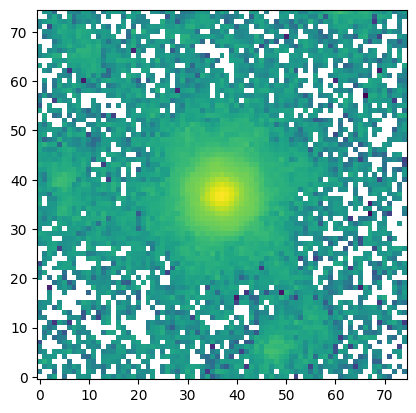

In [34]:
cut = pyfits.open("cutout-f444w-clear_drc_sci.fits")
cut.info()

plt.imshow(np.log10(cut[0].data), origin='lower')

In [35]:
Image(url=SLIT_URL.format(**row), height=300, width=300)

# GNz11 Exercise

Using the code similar to the section above, make cutout thumbnails of all F444W observations of GN-z11 with epoch rounded to the nearest day or two and measure the brightness in each.  

Use ``(ra, dec) = (189.1060833, 62.2420556)`` for GNz11.



In [44]:
# Query DJA exposures that cover a particular position
ra, dec = 189.1060833, 62.2420556

res = utils.read_catalog(SLIT_URL.format(ra=ra, dec=dec, metafile='').replace('/thumb','/exposures'), format='csv')

download_res_files(res)
res

http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123628p6214_unknown-f444w-grismr_00042/Prep/jw01895002003_03106_00001_nrcalong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123624p6213_unknown-f444w-grismr_00024/Prep/jw01895002002_02106_00001_nrcalong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00090/Prep/jw01181003001_02101_00001_nrcblong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00090/Prep/jw01181003001_02101_00005_nrcblong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00090/Prep/jw01181003001_02101_00002_nrcblong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00090/Prep/jw01181003001_02101_00003_nrcblong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00090/Prep/jw01181003001_02101_00004_nrcblong_rate.fits
http://s3.amazonaws.com/grizli-v2/HST/Pipeline/j123648p6213_goods-n-f444w_00

file,extension,dataset,assoc,parent,filter,pupil,mdrizsky,exptime,expstart,sciext,instrume,detector,ndq,expflag,sunangle,gsky101,gsky102,gsky103,persnpix,perslevl,naxis1,naxis2,crpix1,crpix2,crval1,crval2,cd11,cd12,cd21,cd22,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,footprint,modtime,chipsky,eid
str34,str4,str34,str39,str48,str11,str5,float64,float64,float64,int64,str6,str8,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str89,float64,float64,int64
jw01895002003_03106_00001_nrcalong,rate,jw01895002003_03106_00001_nrcalong,j123628p6214_unknown-f444w-grismr_00042,goods-n-center-01895-002-230.0-nrca5-f444w-clear,F444W-CLEAR,CLEAR,0.23963264,311.366,59987.16,1,NIRCAM,NRCALONG,361164,--,--,--,--,--,--,--,2048,2048,1025,1025,189.11288,62.264442,1.1101463e-05,-1.3524463e-05,-1.3441209e-05,-1.1133908e-05,189.11789,62.28983,189.05899,62.2667,189.10721,62.239346,189.1677,62.26196,"((189.11789,62.28983),(189.05899,62.2667),(189.10721,62.239346),(189.1677,62.26196))",60716.598,0.0,416352
jw01895002002_02106_00001_nrcalong,rate,jw01895002002_02106_00001_nrcalong,j123624p6213_unknown-f444w-grismr_00024,goods-n-center-01895-002-230.0-nrca5-f444w-clear,F444W-CLEAR,CLEAR,0.23990557,311.366,59986.543,1,NIRCAM,NRCALONG,484005,--,--,--,--,--,--,--,2048,2048,1025,1025,189.05447,62.24288,1.1110751e-05,-1.35167775e-05,-1.3433546e-05,-1.1143252e-05,189.05943,62.268265,189.00061,62.24512,189.04883,62.21778,189.10925,62.240414,"((189.05943,62.268265),(189.00061,62.24512),(189.04883,62.21778),(189.10925,62.240414))",60716.645,0.0,419140
jw01181003001_02101_00001_nrcblong,rate,jw01181003001_02101_00001_nrcblong,j123648p6213_goods-n-f444w_00090,goods-n-01181-003-241.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.23323132,515.365,59978.56,1,NIRCAM,NRCBLONG,433755,--,--,--,--,--,--,--,2048,2048,1024,1025,189.07819,62.23857,8.428344e-06,-1.5352982e-05,-1.5291673e-05,-8.488596e-06,189.09344,62.26325,189.0259,62.245354,189.0629,62.21439,189.13078,62.231377,"((189.09344,62.26325),(189.0259,62.245354),(189.0629,62.21439),(189.13078,62.231377))",60716.605,0.0,416687
jw01181003001_02101_00005_nrcblong,rate,jw01181003001_02101_00005_nrcblong,j123648p6213_goods-n-f444w_00090,goods-n-01181-003-241.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.23540665,515.365,59978.586,1,NIRCAM,NRCBLONG,431875,--,--,--,--,--,--,--,2048,2048,1024,1025,189.06865,62.23984,8.430578e-06,-1.5351741e-05,-1.529044e-05,-8.490839e-06,189.0839,62.26452,189.01636,62.24662,189.05338,62.215656,189.12125,62.23265,"((189.0839,62.26452),(189.01636,62.24662),(189.05338,62.215656),(189.12125,62.23265))",60716.605,0.0,416692
jw01181003001_02101_00002_nrcblong,rate,jw01181003001_02101_00002_nrcblong,j123648p6213_goods-n-f444w_00090,goods-n-01181-003-241.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.23456942,515.365,59978.566,1,NIRCAM,NRCBLONG,442395,--,--,--,--,--,--,--,2048,2048,1024,1025,189.07716,62.238476,8.428539e-06,-1.5352873e-05,-1.5291564e-05,-8.4887915e-06,189.09242,62.26315,189.02487,62.245255,189.06187,62.21429,189.12976,62.231277,"((189.09242,62.26315),(189.02487,62.245255),(189.06187,62.21429),(189.12976,62.231277))",60716.605,0.0,416688
jw01181003001_02101_00003_nrcblong,rate,jw01181003001_02101_00003_nrcblong,j123648p6213_goods-n-f444w_00090,goods-n-01181-003-241.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.23429766,515.365,59978.574,1,NIRCAM,NRCBLONG,442441,--,--,--,--,--,--,--,2048,2048,1024,1025,189.07341,62.23921,8.429452e-06,-1.5352367e-05,-1.5291062e-05,-8.489707e-06,189.08867,62.263885,189.02113,62.245987,189.05814,62.215023,189.12602,62.232014,"((189.08867,62.263885),(189.02113,62.245987),(189.05814,62.215023),(189.12602,62.232014))",60716.605,0.0,416689
jw01181003001_02101_00004_nrcblong,rate,jw01181003001_02101_00004_nrcblong,j123648p6213_goods-n-f444w_00090,goods-n-01181-003-241.0-nrcb5-f444w-clear,F444W-CLEAR,CLEAR,0.23428142,515.365,59978.582,1,NIRCAM,NRCBLONG,434657,--,-

In [45]:
cutout = visit_processor.cutout_mosaic(
    rootname="gnz11",
    ra=ra, dec=dec,
    filters=['F444W-CLEAR'],
    clean_flt=False,
    s3output=None,
    res=res,
    ir_scale=0.04,
    half_optical=False,
    size=1.5 * 2,
    kernel='square',
    pixfrac=0.5,
    make_exptime_map=False,
    skip_existing=False,
)

============ gnz11-f444w-clear============

(   1/  17) Add exposure jw01181002001_02101_00001_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=143 plus=0
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 381  ( 0.009 %)
Found 0 saturated pixels in 0  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+NO_SAT_CHECK+NO_GAIN_VALUE+HOT+WARM+DEAD+RC+LOW_QE = 1097366529


2025-06-04 15:15:12,221 - stpipe - WARNING - ! 4191966 points were outside the output image.
2025-06-04 15:15:12,263 - stpipe - WARNING - ! 4191966 points were outside the output image.


  ext (SCI,1), sky=0.235 has_bkg:True median_weight:8.60e+03
# (2025-06-04 15:15:12.191)
Drizzle array 1/1

(   2/  17) Add exposure jw01181002001_02101_00002_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=128 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 269  ( 0.006 %)
Found 336 saturated pixels in 1  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS

2025-06-04 15:15:14,175 - stpipe - WARNING - ! 4191966 points were outside the output image.
2025-06-04 15:15:14,212 - stpipe - WARNING - ! 4191966 points were outside the output image.


  ext (SCI,1), sky=0.234 has_bkg:True median_weight:8.63e+03
# (2025-06-04 15:15:14.145)
Drizzle array 1/1

(   3/  17) Add exposure jw01181002001_02101_00003_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=124 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 313  ( 0.007 %)
Found 694 saturated pixels in 2  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS

2025-06-04 15:15:15,986 - stpipe - WARNING - ! 4191963 points were outside the output image.
2025-06-04 15:15:16,033 - stpipe - WARNING - ! 4191963 points were outside the output image.


  ext (SCI,1), sky=0.236 has_bkg:True median_weight:8.56e+03
# (2025-06-04 15:15:15.951)
Drizzle array 1/1

(   4/  17) Add exposure jw01181002001_02101_00004_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=131 plus=8
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 266  ( 0.006 %)
Found 1350 saturated pixels in 3  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:17,804 - stpipe - WARNING - ! 4191964 points were outside the output image.
2025-06-04 15:15:17,867 - stpipe - WARNING - ! 4191964 points were outside the output image.


  ext (SCI,1), sky=0.235 has_bkg:True median_weight:8.58e+03
# (2025-06-04 15:15:17.766)
Drizzle array 1/1

(   5/  17) Add exposure jw01181002001_02101_00005_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=129 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 273  ( 0.007 %)
Found 1684 saturated pixels in 4  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:20,483 - stpipe - WARNING - ! 4191965 points were outside the output image.
2025-06-04 15:15:20,549 - stpipe - WARNING - ! 4191965 points were outside the output image.


  ext (SCI,1), sky=0.234 has_bkg:True median_weight:8.62e+03
# (2025-06-04 15:15:20.427)
Drizzle array 1/1

(   6/  17) Add exposure jw01181002001_02101_00006_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=127 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 323  ( 0.008 %)
Found 2128 saturated pixels in 5  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:23,254 - stpipe - WARNING - ! 4191965 points were outside the output image.
2025-06-04 15:15:23,327 - stpipe - WARNING - ! 4191965 points were outside the output image.


  ext (SCI,1), sky=0.236 has_bkg:True median_weight:8.57e+03
# (2025-06-04 15:15:23.201)
Drizzle array 1/1

(   7/  17) Add exposure jw01181003001_02101_00001_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=135 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 347  ( 0.008 %)
Found 0 saturated pixels in 0  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+N

2025-06-04 15:15:26,410 - stpipe - WARNING - ! 4192022 points were outside the output image.
2025-06-04 15:15:26,452 - stpipe - WARNING - ! 4192022 points were outside the output image.


  ext (SCI,1), sky=0.233 has_bkg:True median_weight:8.66e+03
# (2025-06-04 15:15:26.378)
Drizzle array 1/1

(   8/  17) Add exposure jw01181003001_02101_00002_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=117 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 302  ( 0.007 %)
Found 544 saturated pixels in 1  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS

2025-06-04 15:15:28,148 - stpipe - WARNING - ! 4192022 points were outside the output image.
2025-06-04 15:15:28,187 - stpipe - WARNING - ! 4192022 points were outside the output image.


  ext (SCI,1), sky=0.235 has_bkg:True median_weight:8.61e+03
# (2025-06-04 15:15:28.116)
Drizzle array 1/1

(   9/  17) Add exposure jw01181003001_02101_00003_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=130 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 297  ( 0.007 %)
Found 813 saturated pixels in 2  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS

2025-06-04 15:15:29,989 - stpipe - WARNING - ! 4192026 points were outside the output image.
2025-06-04 15:15:30,039 - stpipe - WARNING - ! 4192026 points were outside the output image.


  ext (SCI,1), sky=0.234 has_bkg:True median_weight:8.62e+03
# (2025-06-04 15:15:29.954)
Drizzle array 1/1

(  10/  17) Add exposure jw01181003001_02101_00004_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=123 plus=8
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 285  ( 0.007 %)
Found 1375 saturated pixels in 3  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:31,834 - stpipe - WARNING - ! 4192031 points were outside the output image.
2025-06-04 15:15:31,883 - stpipe - WARNING - ! 4192031 points were outside the output image.


  ext (SCI,1), sky=0.234 has_bkg:True median_weight:8.62e+03
# (2025-06-04 15:15:31.799)
Drizzle array 1/1

(  11/  17) Add exposure jw01181003001_02101_00005_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=140 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 306  ( 0.007 %)
Found 1598 saturated pixels in 4  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:33,788 - stpipe - WARNING - ! 4192034 points were outside the output image.
2025-06-04 15:15:33,832 - stpipe - WARNING - ! 4192034 points were outside the output image.


  ext (SCI,1), sky=0.235 has_bkg:True median_weight:8.58e+03
# (2025-06-04 15:15:33.756)
Drizzle array 1/1

(  12/  17) Add exposure jw01181003001_02101_00006_nrcblong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCBLONG.fits.gz
flag_nircam_hot_pixels : hot=149 plus=8
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 322  ( 0.008 %)
Found 1798 saturated pixels in 5  previous NRCBLONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCBLONG-F444W-CLEAR mjsr=0.3710 scale=1.0000 pixar_sr=9.24e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.371  0.371  scale = 1.000
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCBLONG-F444W-CLEAR not found
  0    PHOTFLAM=1.42e-21, scale=1.000
       PHOTFLAM=1.42e-21, scale=1.000
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIA

2025-06-04 15:15:36,156 - stpipe - WARNING - ! 4192041 points were outside the output image.
2025-06-04 15:15:36,217 - stpipe - WARNING - ! 4192041 points were outside the output image.


  ext (SCI,1), sky=0.234 has_bkg:True median_weight:8.64e+03
# (2025-06-04 15:15:36.110)
Drizzle array 1/1

(  13/  17) Add exposure jw01895002002_02106_00001_nrcalong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCALONG.fits.gz
flag_nircam_hot_pixels : hot=19 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 733  ( 0.02 %)


CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/nircam/jwst_nircam_photom_0136.fits   17.3 K bytes  (1 / 1 files) (0 / 17.3 K bytes)


Found 0 saturated pixels in 0  previous NRCALONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCALONG-F444W-CLEAR mjsr=0.4020 scale=0.9645 pixar_sr=9.21e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.402  0.388  scale = 0.964
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCALONG-F444W-CLEAR not found
  0    PHOTFLAM=1.37e-21, scale=1.000
       PHOTFLAM=1.37e-21, scale=0.962
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+NO_SAT_CHECK+NO_GAIN_VALUE+HOT+WARM+DEAD+RC+LOW_QE = 1097366529


2025-06-04 15:15:39,423 - stpipe - WARNING - ! 4192828 points were outside the output image.
2025-06-04 15:15:39,460 - stpipe - WARNING - ! 4192828 points were outside the output image.


  ext (SCI,1), sky=0.240 has_bkg:True median_weight:4.94e+03
# (2025-06-04 15:15:39.396)
Drizzle array 1/1

(  14/  17) Add exposure jw01895002003_03106_00001_nrcalong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCALONG.fits.gz
flag_nircam_hot_pixels : hot=27 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 300  ( 0.007 %)
Found 0 saturated pixels in 0  previous NRCALONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCALONG-F444W-CLEAR mjsr=0.4020 scale=0.9645 pixar_sr=9.21e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.402  0.388  scale = 0.964
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCALONG-F444W-CLEAR not found
  0    PHOTFLAM=1.37e-21, scale=1.000
       PHOTFLAM=1.37e-21, scale=0.962
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+NO

2025-06-04 15:15:41,813 - stpipe - WARNING - ! 4191949 points were outside the output image.
2025-06-04 15:15:41,851 - stpipe - WARNING - ! 4191949 points were outside the output image.


  ext (SCI,1), sky=0.240 has_bkg:True median_weight:4.96e+03
# (2025-06-04 15:15:41.783)
Drizzle array 1/1

(  15/  17) Add exposure jw01895002004_03104_00001_nrcalong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCALONG.fits.gz
flag_nircam_hot_pixels : hot=26 plus=12
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 326  ( 0.008 %)
Found 0 saturated pixels in 0  previous NRCALONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCALONG-F444W-CLEAR mjsr=0.4020 scale=0.9645 pixar_sr=9.21e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.402  0.388  scale = 0.964
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCALONG-F444W-CLEAR not found
  0    PHOTFLAM=1.37e-21, scale=1.000
       PHOTFLAM=1.37e-21, scale=0.962
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+N

2025-06-04 15:15:43,592 - stpipe - WARNING - ! 4191917 points were outside the output image.
2025-06-04 15:15:43,644 - stpipe - WARNING - ! 4191917 points were outside the output image.


  ext (SCI,1), sky=0.240 has_bkg:True median_weight:4.96e+03
# (2025-06-04 15:15:43.551)
Drizzle array 1/1

(  16/  17) Add exposure jw01895002004_03106_00001_nrcalong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCALONG.fits.gz
flag_nircam_hot_pixels : hot=27 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 369  ( 0.009 %)
Found 39 saturated pixels in 1  previous NRCALONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCALONG-F444W-CLEAR mjsr=0.4020 scale=0.9645 pixar_sr=9.21e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.402  0.388  scale = 0.964
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCALONG-F444W-CLEAR not found
  0    PHOTFLAM=1.37e-21, scale=1.000
       PHOTFLAM=1.37e-21, scale=0.962
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+N

2025-06-04 15:15:45,417 - stpipe - WARNING - ! 4191920 points were outside the output image.
2025-06-04 15:15:45,461 - stpipe - WARNING - ! 4191920 points were outside the output image.


  ext (SCI,1), sky=0.239 has_bkg:True median_weight:4.97e+03
# (2025-06-04 15:15:45.387)
Drizzle array 1/1

(  17/  17) Add exposure jw01895002004_03106_00002_nrcalong_rate.fits (weight_type='jwst_var', rnoise_percentile=99)

Use extra badpix in /usr/local/lib/python3.11/dist-packages/grizli/data/nrc_badpix_240627_NRCALONG.fits.gz
flag_nircam_hot_pixels : hot=17 plus=4
# prep.apply_region_mask_from_db: query failed
Extra -5 sigma low pixels: N= 312  ( 0.007 %)
Found 341 saturated pixels in 2  previous NRCALONG exposures within 10000 sec
get_nircam_zeropoint_update: NRCALONG-F444W-CLEAR mjsr=0.4020 scale=0.9645 pixar_sr=9.21e-14
jwst_crds_photom_scale: jwst_1123.pmap photmjsr old, new = 0.402  0.388  scale = 0.964
get_photom_scale /usr/local/lib/python3.11/dist-packages/grizli/data/photom_correction.yml: NRCALONG-F444W-CLEAR not found
  0    PHOTFLAM=1.37e-21, scale=1.000
       PHOTFLAM=1.37e-21, scale=0.962
get_jwst_dq_bits: DO_NOT_USE+OTHER_BAD_PIXEL+UNRELIABLE_SLOPE+UNRELIABLE_BIAS+

2025-06-04 15:15:47,518 - stpipe - WARNING - ! 4191914 points were outside the output image.
2025-06-04 15:15:47,587 - stpipe - WARNING - ! 4191914 points were outside the output image.


  ext (SCI,1), sky=0.239 has_bkg:True median_weight:4.96e+03
# (2025-06-04 15:15:47.469)
Drizzle array 1/1
Scale PHOTFNU x 0.108 to 10.0 nJy


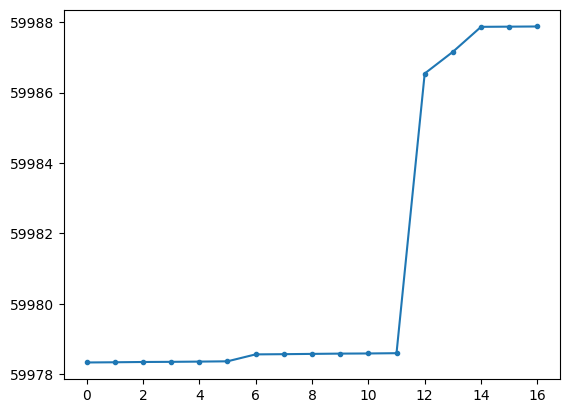

In [37]:
so = np.argsort(res['expstart'])
res = res[so]
plt.plot(res['expstart'], marker='.')

In [49]:
import astropy.wcs as pywcs
import astropy.io.fits as pyfits
import sep

cut = pyfits.open("gnz11-f444w-clear_drc_sci.fits")

wcs = pywcs.WCS(cut[0].header)

x_pixel, y_pixel = np.squeeze(wcs.all_world2pix([ra], [dec], 0))
print(x_pixel, y_pixel)

# Do photometry
cut_var = pyfits.open("gnz11-f444w-clear_drc_var.fits")

data_sci = cut[0].data.astype(np.float32)
data_var = cut_var[0].data.astype(np.float32)


37.0 36.99999999968425


In [52]:
radius = 0.5 / 0.04

phot = sep.sum_circle(data_sci, [x_pixel], [y_pixel], radius, var=data_var)



In [55]:
cut[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                 38.0 / Pixel coordinate of reference point            
CRPIX2  =                 38.0 / Pixel coordinate of reference point            
CD1_1   = -1.1111111111111E-05 / Coordinate transformation matrix element       
CD2_2   = 1.11111111111111E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [58]:
shutters = utils.read_catalog(
    SLIT_URL.format(ra=ra, dec=dec, metafile='').replace('thumb?', 'nirspec_slits?'), format='csv'
)


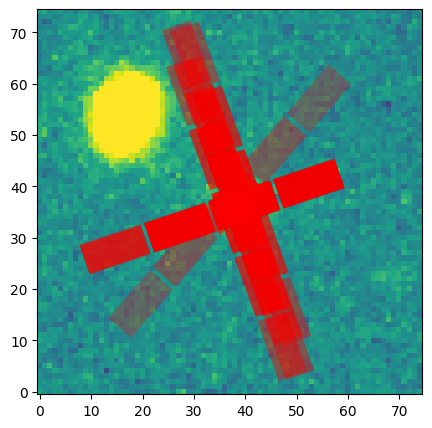

In [72]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(data_sci, vmin=-0.1, vmax=0.1, origin='lower')

# Draw shutters
for row in shutters:
    sr = utils.SRegion(row['footprint'])
    xy = wcs.all_world2pix(sr.xy[0], 0)
    sr_pix = utils.SRegion(xy, wrap=False)
    sr_pix.add_patch_to_axis(ax, fc='r', ec='None', alpha=0.1)


In [74]:
Image(url=SLIT_URL.format(ra=ra, dec=dec, metafile=""), height=300, width=300)

In [76]:
# Match to spectrum table
gnz11 = utils.read_catalog(f"""ra, dec
{ra}, {dec}""", format="csv")

idx, dr = gnz11.match_to_catalog_sky(tab)

In [82]:
is_gnz11 = dr.value < 0.5
is_gnz11.sum()

12

In [83]:
# Show the spectra
df = tab['root','file','z_best','Mass','ha_eqw_with_limits','Thumb','Slit_Thumb','Spectrum_fnu', 'Spectrum_flam'][is_gnz11].to_pandas()

display(Markdown(df.to_markdown()))


|    | root            | file                                             |   z_best |   Mass |   ha_eqw_with_limits | Thumb                                                                                                                                                                                                         | Slit_Thumb                                                                                                                                                                                                                                                  | Spectrum_fnu                                                                                                                                | Spectrum_flam                                                                                                                                |
|---:|:----------------|:-------------------------------------------------|---------:|-------:|---------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | goodsn-wide0-v4 | goodsn-wide0-v4_g235h-f170lp_1211_1268.spec.fits |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01211020001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_g235h-f170lp_1211_1268.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_g235h-f170lp_1211_1268.flam.png" height=200px> |
|  1 | goodsn-wide0-v4 | goodsn-wide0-v4_g395h-f290lp_1211_1268.spec.fits |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01211020001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_g395h-f290lp_1211_1268.fnu.png" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_g395h-f290lp_1211_1268.flam.png" height=200px> |
|  2 | goodsn-wide0-v4 | goodsn-wide0-v4_prism-clear_1211_1268.spec.fits  |  10.6037 |   -inf |                    0 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.10605425%2C62.24204894&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01211020001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_prism-clear_1211_1268.fnu.png" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/goodsn-wide0-v4/goodsn-wide0-v4_prism-clear_1211_1268.flam.png" height=200px>  |
|  3 | jades-gdn11-v4  | jades-gdn11-v4_g140m-f070lp_1181_5591.spec.fits  |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181011001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g140m-f070lp_1181_5591.fnu.png" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g140m-f070lp_1181_5591.flam.png" height=200px>   |
|  4 | jades-gdn11-v4  | jades-gdn11-v4_g235m-f170lp_1181_5591.spec.fits  |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181011001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g235m-f170lp_1181_5591.fnu.png" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g235m-f170lp_1181_5591.flam.png" height=200px>   |
|  5 | jades-gdn11-v4  | jades-gdn11-v4_g395h-f290lp_1181_5591.spec.fits  |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181011001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g395h-f290lp_1181_5591.fnu.png" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g395h-f290lp_1181_5591.flam.png" height=200px>   |
|  6 | jades-gdn11-v4  | jades-gdn11-v4_g395m-f290lp_1181_5591.spec.fits  |  10.6037 |   -inf |                    0 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181011001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g395m-f290lp_1181_5591.fnu.png" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_g395m-f290lp_1181_5591.flam.png" height=200px>   |
|  7 | jades-gdn11-v4  | jades-gdn11-v4_prism-clear_1181_5591.spec.fits   |  10.6037 |   -inf |                    0 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060426%2C62.2420448&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181011001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_prism-clear_1181_5591.fnu.png" height=200px>    | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn11-v4/jades-gdn11-v4_prism-clear_1181_5591.flam.png" height=200px>    |
|  8 | jades-gdn2-v4   | jades-gdn2-v4_g140m-f070lp_1181_3991.spec.fits   |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181005001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g140m-f070lp_1181_3991.fnu.png" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g140m-f070lp_1181_3991.flam.png" height=200px>     |
|  9 | jades-gdn2-v4   | jades-gdn2-v4_g235m-f170lp_1181_3991.spec.fits   |  10.6037 |    nan |                  nan | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181007001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g235m-f170lp_1181_3991.fnu.png" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g235m-f170lp_1181_3991.flam.png" height=200px>     |
| 10 | jades-gdn2-v4   | jades-gdn2-v4_g395m-f290lp_1181_3991.spec.fits   |  10.6037 |   -inf |                    0 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181007001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g395m-f290lp_1181_3991.fnu.png" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_g395m-f290lp_1181_3991.flam.png" height=200px>     |
| 11 | jades-gdn2-v4   | jades-gdn2-v4_prism-clear_1181_3991.spec.fits    |  10.6037 |   -inf |                    0 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=189.1060542%2C62.2420489&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01181005001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_prism-clear_1181_3991.fnu.png" height=200px>      | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn2-v4/jades-gdn2-v4_prism-clear_1181_3991.flam.png" height=200px>      |